In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

plt.style.use('ggplot')

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam,RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


In [130]:
clf = Sequential([
    Dense(units=256, kernel_initializer='uniform', input_dim=100, activation='relu'),
    Dense(units=512, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(128, kernel_initializer='uniform', activation='relu'),
    Dense(64, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(64, kernel_initializer='uniform', activation='relu'),
    Dense(64, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_66 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_68 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
__________

In [131]:
from sklearn.metrics import roc_curve, auc
from keras import backend as K  

def ant_score(y_true, y_pred):  
    fpr, tpr, thresholds = roc_curve(y_true,y_pred)
    roc_auc = auc(fpr, tpr)
    roc_result = pd.DataFrame()
    roc_result['fpr'] = pd.Series(fpr)
    roc_result['tpr'] = pd.Series(tpr)
    roc_result['thresholds'] = pd.Series(thresholds)
    TPR1= float(roc_result[roc_result['fpr']<=0.001002].tail(1)['tpr'])
    TPR2=float(roc_result[roc_result['fpr']<=0.005002].tail(1)['tpr'])
    TPR3=float(roc_result[roc_result['fpr']<=0.010002].tail(1)['tpr'])
    FINAL_SCORE = 0.4*TPR1 + 0.3*TPR2 + 0.3 * TPR3 
    return FINAL_SCORE

def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # N = total number of negative labels  
    N = K.sum(1 - y_true)  
    # FP = total number of false alerts, alerts from the negative class labels  
    FP = K.sum(y_pred - y_pred * y_true)  
    return FP/N  

def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # P = total number of positive labels  
    P = K.sum(y_true)  
    # TP = total number of correct alerts, alerts from the positive class labels  
    TP = K.sum(y_pred * y_true)  
    return TP/P 


def auc(y_true, y_pred):  
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)  
    binSizes = -(pfas[1:]-pfas[:-1])  
    s = ptas*binSizes  
    return K.sum(s, axis=0)  

clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
train_proba = pd.read_pickle('./train_proba.dat')
verify_proba = pd.read_pickle('./verify_proba.dat')
test_proba = pd.read_pickle('./test_proba.dat')

In [133]:
predictors = [x for x in train_proba.columns if x not in ['Fraud','Normal']]
target='Fraud'
X_train=train_proba[predictors]
y_train=train_proba[target]

X_verify=verify_proba[predictors]
y_verify=verify_proba[target]


In [140]:
clf.fit(X_verify, y_verify, batch_size=2048, epochs=300)

Epoch 1/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9904
Epoch 2/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9904
Epoch 3/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0266 - acc: 0.9904
Epoch 4/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9902
Epoch 5/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9904
Epoch 6/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9904
Epoch 7/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0264 - acc: 0.9904
Epoch 8/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0265 - acc: 0.9904
Epoch 9/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0264 - acc: 0.9904
Epoch 10/300
344113/344113 [==============================] - 3s 8us/step - loss: 

344113/344113 [==============================] - 3s 8us/step - loss: 0.0259 - acc: 0.9907
Epoch 81/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0255 - acc: 0.9907
Epoch 82/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0254 - acc: 0.9907
Epoch 83/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0256 - acc: 0.9907
Epoch 84/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0256 - acc: 0.9907
Epoch 85/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0255 - acc: 0.9907
Epoch 86/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0254 - acc: 0.9908
Epoch 87/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0254 - acc: 0.9906
Epoch 88/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0253 - acc: 0.9907
Epoch 89/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.02

344113/344113 [==============================] - 3s 8us/step - loss: 0.0247 - acc: 0.9909
Epoch 160/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0247 - acc: 0.9909
Epoch 161/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0247 - acc: 0.9909
Epoch 162/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0245 - acc: 0.9910
Epoch 163/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0245 - acc: 0.9909
Epoch 164/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0247 - acc: 0.9909
Epoch 165/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0249 - acc: 0.9909
Epoch 166/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0246 - acc: 0.9910
Epoch 167/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0245 - acc: 0.9910
Epoch 168/300
344113/344113 [==============================] - 3s 8us/step - l

344113/344113 [==============================] - 3s 8us/step - loss: 0.0242 - acc: 0.9912
Epoch 238/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0242 - acc: 0.9911
Epoch 239/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0242 - acc: 0.9911
Epoch 240/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0242 - acc: 0.9911
Epoch 241/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0242 - acc: 0.9910
Epoch 242/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0243 - acc: 0.9910
Epoch 243/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0243 - acc: 0.9910
Epoch 244/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0241 - acc: 0.9911
Epoch 245/300
344113/344113 [==============================] - 3s 8us/step - loss: 0.0249 - acc: 0.9908
Epoch 246/300
344113/344113 [==============================] - 3s 8us/step - l

In [135]:
y_verify_proba = clf.predict_proba(X_verify)

0.5141935483870967


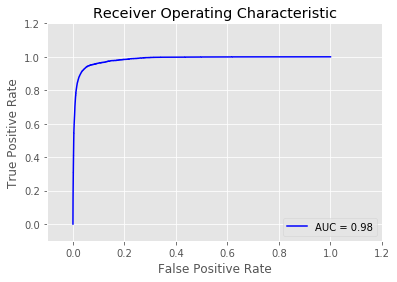

In [136]:
a,b,c=atecml.data.accuracy_validation(y_verify,y_verify_proba)

In [137]:
test_df = atecml.data.load_test()
result_proba = clf.predict_proba(test_proba)


In [138]:
result = pd.DataFrame()
result['id'] =test_df['id']
result['score'] =pd.DataFrame(result_proba)[0]

In [139]:
result.set_index('id').to_csv('./submit_20180625_4.csv')    